In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# !pip install transformers

In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from datetime import datetime
import sys
import seaborn as sns
sns.set(style="darkgrid")
from pdb import set_trace
import warnings
warnings.filterwarnings("ignore")

#local
BASE_PATH = "/content/drive/My Drive/collab/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/"
sys.path.append(BASE_PATH+"TADAT/")

from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
def vectorize_data(train_split, test_split, test_split_M, test_split_F):
    #vectorize instances
    train_X = data.getX(train_split)
    test_X_M = data.getX(test_split_M)
    test_X_F = data.getX(test_split_F)
    test_X = data.getX(test_split)
    
    train_X, word_vocab = vectorizer.docs2idx(train_X)
    test_X_M,_ = vectorizer.docs2idx(test_X_M, word_vocab)
    test_X_F,_ = vectorizer.docs2idx(test_X_F, word_vocab)
    test_X,_ = vectorizer.docs2idx(test_X, word_vocab)
    
    #vectorize labels
    train_Y = data.getY(train_split)
    test_Y_M = data.getY(test_split_M) 
    test_Y_F = data.getY(test_split_F)   
    test_Y = data.getY(test_split)   
    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    test_Y_M,_ = vectorizer.label2idx(test_Y_M, label_vocab)
    test_Y_F,_ = vectorizer.label2idx(test_Y_F, label_vocab)
    
    return train_X, train_Y, test_X, test_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-bin":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-freq":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-bin":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-sum": 
        X = features.BOE(data, word_vectors,"sum")
    else:
        raise NotImplementedError
    return X
    
def get_BERT_embedding(X):
    X_cls, X_pool =  embeddings.transformer_encode_batches(X, batchsize=200, device="cuda")
    return X_cls, X_pool
    

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, res_path=None):
    Y_hat = model.predict(X_test)
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    acc = accuracy_score(Y_test, Y_hat)
    precision, recall, fscore, support = score(Y_test, Y_hat)

    res = {"model":model_name, \
            "seed":random_seed, \
            "acc":round(acc,3), \
            "microF1":round(microF1,3), \
            "macroF1":round(macroF1,3)
            }

    for l, i in labels.items():
        try:
            fs = round(fscore[i],3)
        except IndexError:
            fs = 0
        res["{}-f1".format(l)] = fs
    if res_path is not None:
        cols = ["dataset", "model", "acc", "avgF1"]        
        helpers.save_results(res, res_path, sep="\t")
    return res


def get_deltas(results_M, results_F):
    #resuts
    df_M = pd.DataFrame(results_M)
    df_F = pd.DataFrame(results_F)
    #compute deltas
    df_delta = df_M.sub(df_F.iloc[:,2:])
    df_delta["model"] = df_M["model"]
    df_delta["seed"] = df_M["seed"]   
    return df_delta

def run(df, x_label, y_label, feature_type, target_label, target_value, split=0.8):
    #split into training and test sets
    train_split, test_split = data.shuffle_split_idx(df[y_label], split)
    df_train = df.iloc[train_split,:]
    df_test = df.iloc[test_split,:]
    df_test_M = df_test[df_test[target_label] == target_value]
    df_test_F = df_test[df_test[target_label] != target_value]
    
    print("M: {} | F: {}".format(len(df_test_M),len(df_test_F)))
    #transform the data into the right format
    train = data.read_dataframe(df_train, x_label, y_label)
    test_M = data.read_dataframe(df_test_M, x_label, y_label)
    test_F = data.read_dataframe(df_test_F, x_label, y_label)
    test = data.read_dataframe(df_test, x_label, y_label)
    #get vectorized train/test data 
    train_X, train_Y, test_X, test_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab = vectorize_data(train, test, test_M, test_F)

    if "BOW" in feature_type:
        #extract features
        train_feats = get_features(train_X, len(word_vocab), feature_type)
        test_feats_M = get_features(test_X_M, len(word_vocab), feature_type)
        test_feats_F = get_features(test_X_F, len(word_vocab), feature_type)        
        test_feats = get_features(test_X, len(word_vocab), feature_type)        
    elif "BERT_CLS" == feature_type:
        train_feats, _ = get_BERT_embedding(train)
        test_feats_M, _ = get_BERT_embedding(test_M)
        test_feats_F, _ = get_BERT_embedding(test_F)
        test_feats, _ = get_BERT_embedding(test)
    elif "BERT_POOL" == feature_type:
        _, train_feats = get_BERT_embedding(train)
        _, test_feats_M = get_BERT_embedding(test_M)
        _, test_feats_F = get_BERT_embedding(test_F)
        _, test_feats = get_BERT_embedding(test)
    else:
        raise NotImplementedError    
#     set_trace()
    #train/test classifier for each random seed
    random_seeds = list(range(20))
    results = []
    results_m = []
    results_f = []
#     set_trace()
    for r in random_seeds:
#         print("[running seed: {}]".format(r))
        model = SGDClassifier(random_state=r)
        model.fit(train_feats, train_Y)
        res = evaluate_classifier(model, test_feats, test_Y, label_vocab, feature_type, r)
        results.append(res)
        res_m = evaluate_classifier(model, test_feats_M, test_Y_M, label_vocab, feature_type, r)
        results_m.append(res_m)
        res_f = evaluate_classifier(model, test_feats_F, test_Y_F, label_vocab, feature_type, r)
        results_f.append(res_f)
    return results, results_m, results_f

def plot_densities(df, ax, title=None):
    if title: ax.set_title(title)
    try:
        df.plot.kde(ax=ax, x="seed", y="microF1")
    except:
        pass
    try:
        df.plot.kde(ax=ax, x="seed", y="0-f1")
    except:
        pass
    try:
        df.plot.kde(ax=ax, x="seed", y="1-f1")
    except:
        pass

In [4]:
raw_data_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
out_data_path = BASE_PATH+"MIMIC/DATA/input/"
out_data_path

'/Users/samir/Dev/projects/MIMIC/MIMIC/DATA/input/'

# Analyses

## Ethnicity 

In [42]:
def ethinicity_outcome_anaylsis(df, x_label, y_label, feature_type):
    results_W, results_M_W, results_F_W = run(df, x_label, y_label, feature_type, "ETHNICITY_LABEL", "WHITE", split=0.8)
    results_N, results_M_N, results_F_N = run(df, x_label, y_label, feature_type, "ETHNICITY_LABEL", "BLACK", split=0.8)
    results_A, results_M_A, results_F_A = run(df, x_label, y_label, feature_type, "ETHNICITY_LABEL", "ASIAN", split=0.8)
    results_H, results_M_H, results_F_H = run(df, x_label, y_label, feature_type, "ETHNICITY_LABEL", "HISPANIC", split=0.8)

    #results
    df_delta_W = get_deltas(results_M_W,results_F_W)
    df_delta_N = get_deltas(results_M_N,results_F_N)
    df_delta_A = get_deltas(results_M_A,results_F_A)
    df_delta_H = get_deltas(results_M_H,results_F_H)

    #unstratified results are all the same
    df_res = pd.DataFrame(results_W)
    df_res_W = pd.DataFrame(results_M_W)
    df_res_N = pd.DataFrame(results_M_N)
    df_res_A = pd.DataFrame(results_M_A)
    df_res_H = pd.DataFrame(results_M_H)

    df_delta_W["group"] = ["White v Others"]*len(df_delta_W)
    df_delta_N["group"] = ["Black v Others"]*len(df_delta_N)
    df_delta_A["group"] = ["Asian v Others"]*len(df_delta_A)
    df_delta_H["group"] = ["Hispanic v Others"]*len(df_delta_H)
    
    return df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_delta_W, df_delta_N, df_delta_A, df_delta_H
    
def ethinicity_plot_performance(df, title):
    #plots
    fig, ax = plt.subplots(1,1, sharey=True, figsize=(18,5))
#   plots.plot_df(df=df,ax=ax,x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df,ax=ax,x="seed",ys=["microF1","0-f1","1-f1"], annotation_size=10)
    ax.legend(loc='best')
    fig.suptitle(title ,y=1.01)
    plt.tight_layout()

def ethinicity_plot_deltas(df_delta_W,df_delta_N,df_delta_A,df_delta_H, title):

    df_delta = pd.concat([df_delta_W,df_delta_N,df_delta_A,df_delta_H])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], value_vars=["microF1","0-f1","1-f1"], 
                                        var_name="metric", value_name="delta")

    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, 
                    col="group",sharey=True,legend_out=True)
    ax1, ax2, ax3, ax4 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    ax3.axhline(0, ls='--',c="r")
    ax4.axhline(0, ls='--',c="r")
    lim = max(df_delta_long["delta"].abs()) + 0.05
    ax1.set_ylim([-lim,lim])
    ax2.set_ylim([-lim,lim])
    ax3.set_ylim([-lim,lim])
    ax4.set_ylim([-lim,lim])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()  

def ethnicity_plot_densities(df_W, df_N, df_A, df_H, title):
    #plots
    fig, ax = plt.subplots(1,4, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_W, ax[0], "White")
    plot_densities(df_N, ax[1], "Black")
    plot_densities(df_A, ax[2], "Asian")
    plot_densities(df_H,ax[3], "Hispanic")
    fig.suptitle(title ,y=1.02)
    plt.tight_layout()
    
    
def ethinicity_analysis(df, x_label, y_label, feature_type, outcome_title):
    df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H  = ethinicity_outcome_anaylsis(df, x_label, y_label, feature_type)
    title="{} ({})".format(outcome_title, feature_type)
    ethinicity_plot_performance(df_res, title)
    ethnicity_plot_densities(df_res_W,df_res_N,df_res_A,df_res_H,title)
    ethinicity_plot_deltas(df_res_delta_W, df_res_delta_N,df_res_delta_A,df_res_delta_H, title)

## Ethnicity Binary

In [40]:
def ethnicity_binary_outcome_anaylsis(df, x_label, y_label, feature_type):
    results_W, results_M_W, results_F_W = run(df, x_label, y_label, feature_type, "ETHNICITY_BINARY", "WHITE", split=0.8)
    results_N, results_M_N, results_F_N = run(df, x_label, y_label, feature_type, "ETHNICITY_BINARY", "NON-WHITE", split=0.8)
    #results
    df_delta_W = get_deltas(results_M_W,results_F_W)
    df_delta_N = get_deltas(results_M_N,results_F_N)    
    df_delta_W["group"] = ["White v Others"]*len(df_delta_W)
    df_delta_N["group"] = ["Non-White v Others"]*len(df_delta_N)
    #unstratified results are all the same
    df_res = pd.DataFrame(results_W)    
    df_res_W = pd.DataFrame(results_M_W)
    df_res_N = pd.DataFrame(results_M_N)
    
    return df_res, df_res_W, df_res_N, df_delta_W, df_delta_N
    
def ethnicity_binary_plot_performance(df, title):
    #plots
    fig, ax = plt.subplots(1,1, sharey=True, figsize=(18,5))
#   plots.plot_df(df=df,ax=ax,x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df,ax=ax,x="seed",ys=["microF1","0-f1","1-f1"], annotation_size=10)
    ax.legend(loc='best')
    fig.suptitle(title ,y=1.02)
    plt.tight_layout()

def ethnicity_binary_plot_deltas(df_delta_W,df_delta_N, title):

    df_delta = pd.concat([df_delta_W,df_delta_N])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], value_vars=["microF1","0-f1","1-f1"], 
                                        var_name="metric", value_name="delta")

    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, 
                    col="group",sharey=True,legend_out=True)
    ax1, ax2 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    lim = max(df_delta_long["delta"].abs()) + 0.05
    ax1.set_ylim([-lim,lim])
    ax2.set_ylim([-lim,lim])
    plt.suptitle(title,y=1.02)
    plt.tight_layout()
    plt.show()  
    
def ethnicity_binary_plot_densities(df_W, df_N, title):
    #plots
    fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_W, ax[0], "White")
    plot_densities(df_N, ax[1], "Non-White")
    fig.suptitle(title ,y=1.02)
    plt.tight_layout()

def ethnicity_binary_analysis(df, x_label, y_label, feature_type, outcome_title):
    df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N = ethnicity_binary_outcome_anaylsis(df, x_label, y_label, feature_type)
    title="{} ({})".format(outcome_title, feature_type)
    ethnicity_binary_plot_performance(df_res, title)
    ethnicity_binary_plot_densities(df_res_W,df_res_N,title)
    ethnicity_binary_plot_deltas(df_res_delta_W, df_res_delta_N, title)
    

## Gender 

In [39]:
def gender_outcome_anaylsis(df, x_label, y_label, feature_type):
    results, results_M, results_F = run(df, x_label, y_label, feature_type, "GENDER", "M", split=0.8)
    #results
    df_delta = get_deltas(results_M,results_F)    
    df_res = pd.DataFrame(results)    
    df_res_M = pd.DataFrame(results_M)
    df_res_F = pd.DataFrame(results_F)
    
    return df_res, df_res_M, df_res_F, df_delta
    
def gender_plot_performance(df, title):
    #plots
    fig, ax = plt.subplots(1,1, sharey=True, figsize=(18,5))
#   plots.plot_df(df=df,ax=ax,x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df,ax=ax,x="seed",ys=["microF1","0-f1","1-f1"], annotation_size=10)
    ax.legend(loc='best')
    fig.suptitle(title ,y=1.02)
    plt.tight_layout()

def gender_plot_deltas(df_delta, title):

    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model"], value_vars=["microF1","0-f1","1-f1"], 
                                        var_name="metric", value_name="delta")
    
    lim = max(df_delta_long["delta"].abs()) + 0.05
    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, sharey=True,legend_out=True)
    ax1 = g.axes[0][0]
    ax1.axhline(0, ls='--',c="r")
    ax1.set_ylim([-lim,lim])
    plt.suptitle(title,y=1.02)
    plt.tight_layout()
    plt.show()  

def gender_plot_densities(df_M, df_F, title):
    #plots
    fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_M, ax[0], "Male") 
    plot_densities(df_F, ax[1], "Female") 
    fig.suptitle(title ,y=1.02)
    plt.tight_layout()

def gender_analysis(df, x_label, y_label, feature_type, outcome_title):
    df_res, df_res_M, df_res_F, df_res_delta = gender_outcome_anaylsis(df, x_label, y_label, feature_type)
    title="{} ({})".format(outcome_title, feature_type)
    gender_plot_performance(df_res, title)
    gender_plot_densities(df_res_M, df_res_F, title)
    gender_plot_deltas(df_res_delta, title)
    

    

# Outcomes

## mortality 

In [8]:
df_mortality = pd.read_csv(out_data_path+"mortality.csv",sep="\t", header=None, names=["EXPIRE","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
df_mortality 

,EXPIRE,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,0,admission date: [**2149-6-2**] discharg...,F,BLACK,NON-WHITE
1,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
2,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
3,0,admission date: [**2133-9-3**] d...,M,OTHER,OTHER
4,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
...,...,...,...,...,...
35827,0,admission date: [**2176-1-21**] dischar...,M,OTHER,OTHER
35828,0,admission date: [**2140-6-28**] dischar...,F,WHITE,WHITE
35829,0,admission date: [**2116-8-10**] ...,F,WHITE,WHITE
35830,0,admission date: [**2201-5-26**] ...,F,WHITE,WHITE


M: 4022 | F: 3146


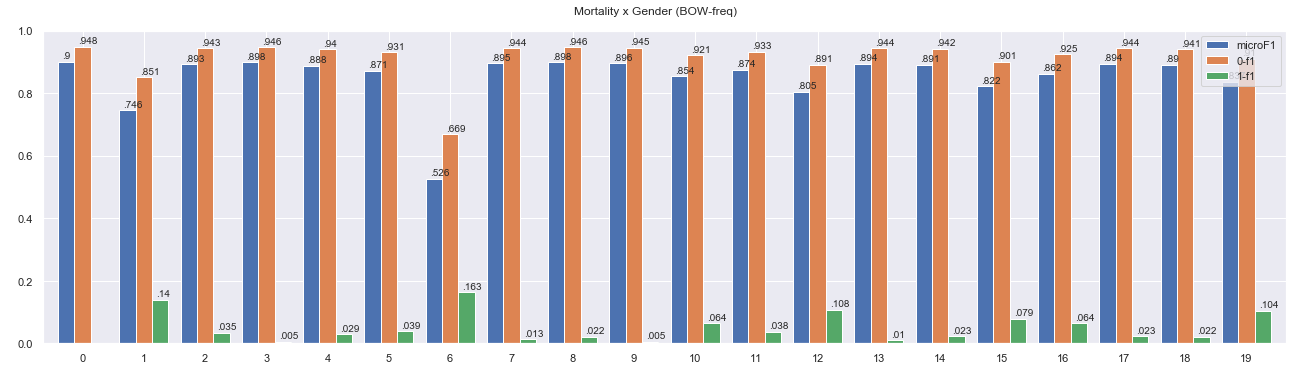

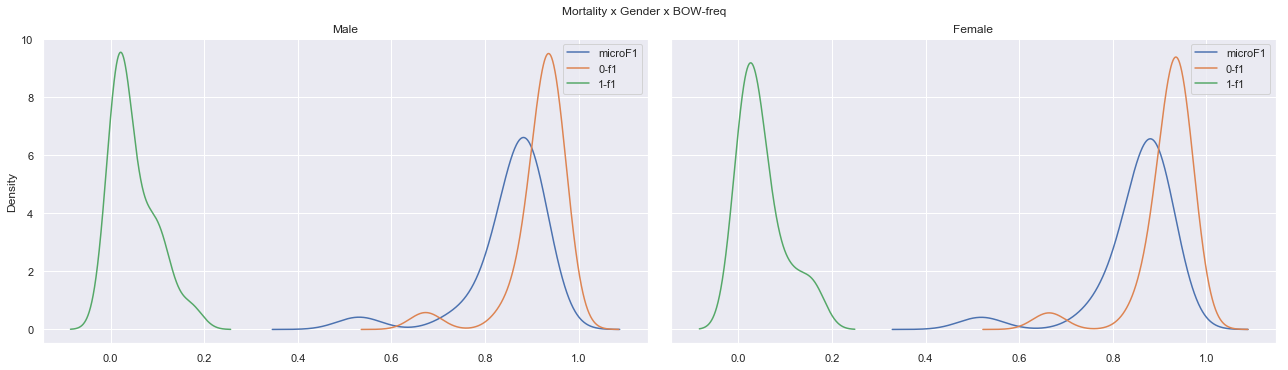

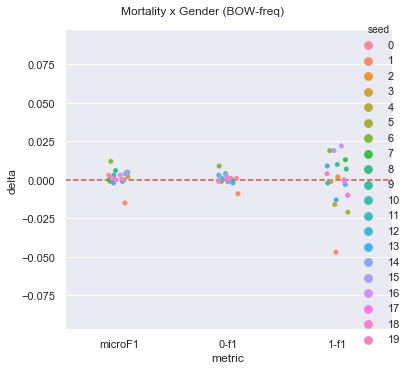

In [14]:
gender_analysis(df_mortality,"TEXT","EXPIRE", "BOW-freq", "Mortality x Gender")



M: 5082 | F: 2086
M: 1141 | F: 6027


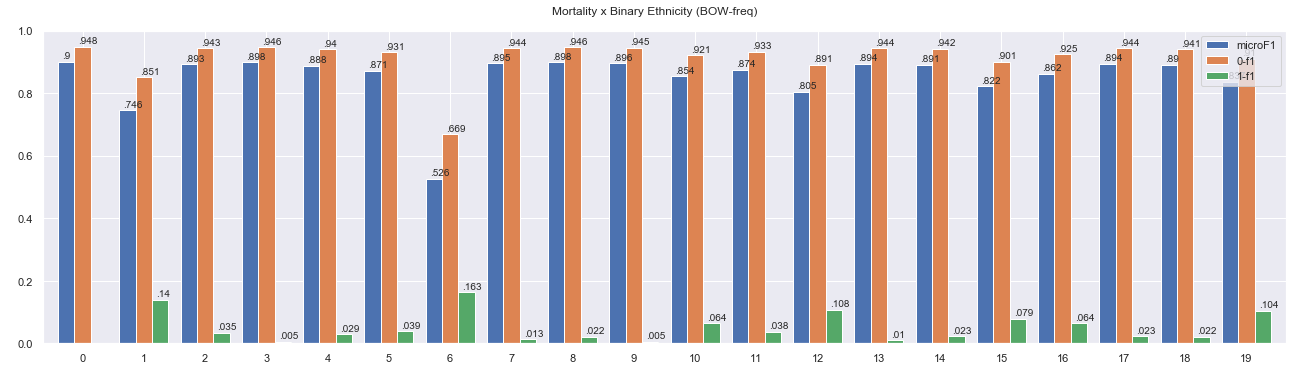

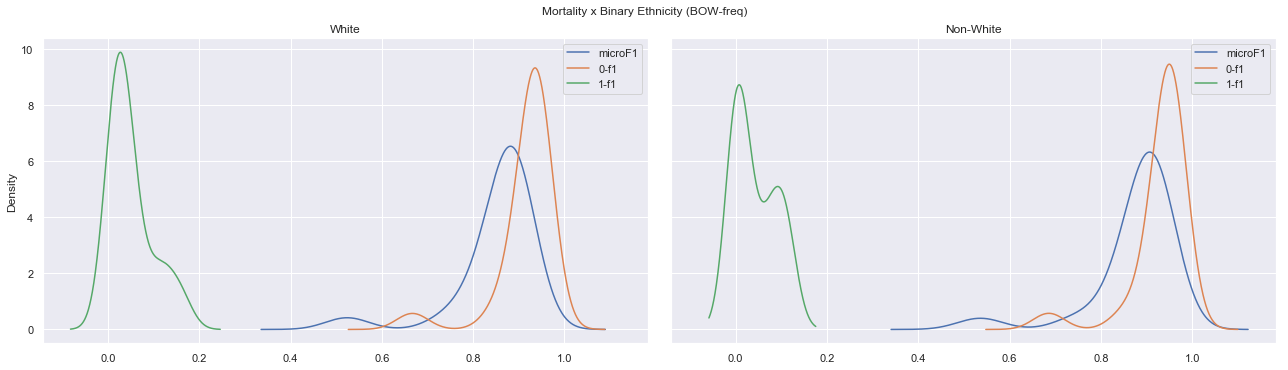

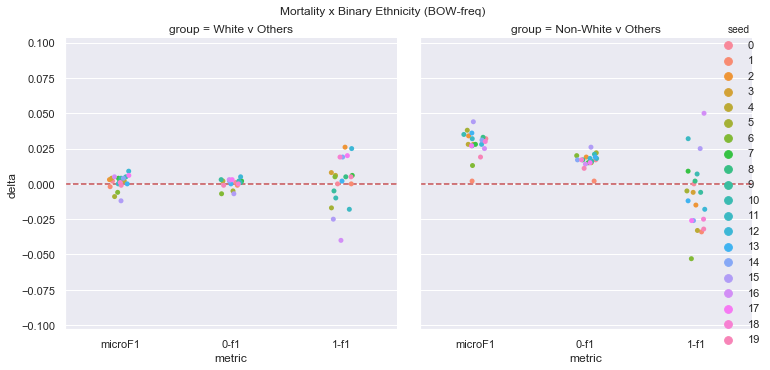

In [13]:
ethnicity_binary_analysis(df_mortality,"TEXT","EXPIRE", "BOW-freq", "Mortality x Binary Ethnicity")

M: 5082 | F: 2086
M: 675 | F: 6493
M: 215 | F: 6953
M: 242 | F: 6926


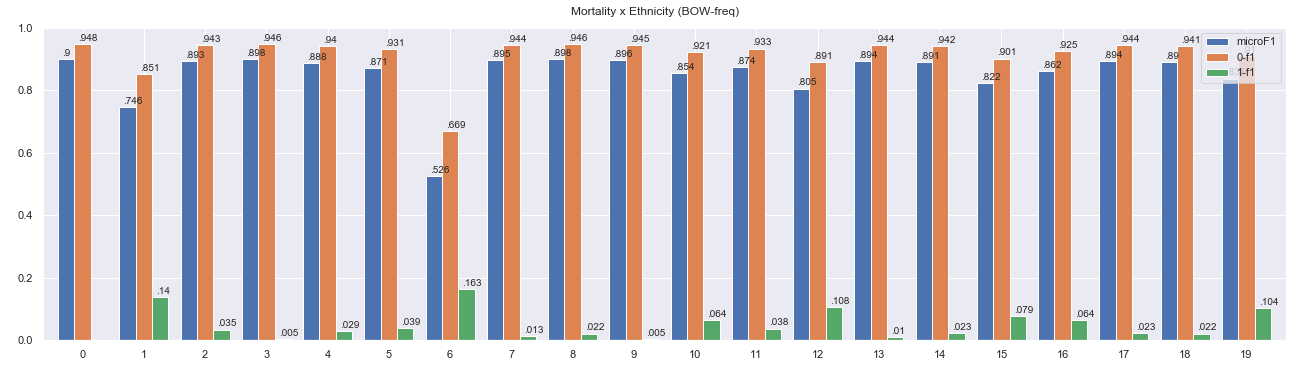

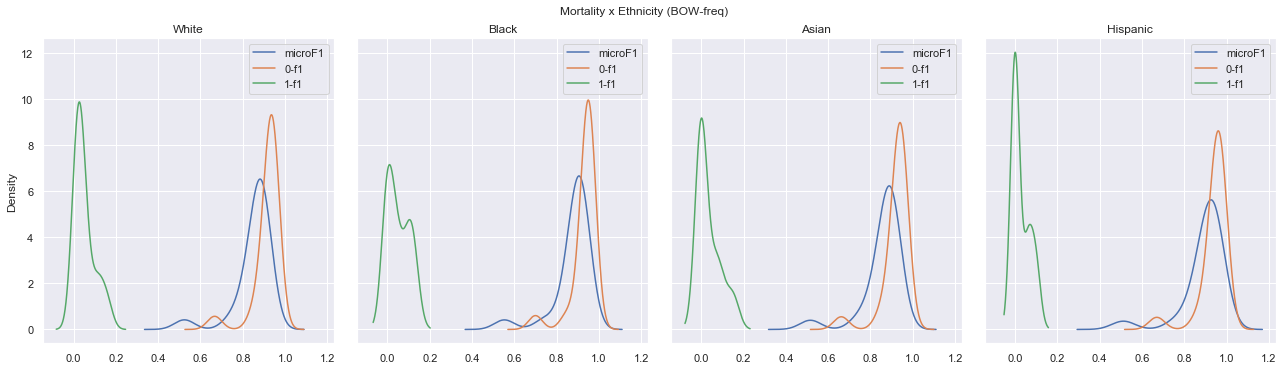

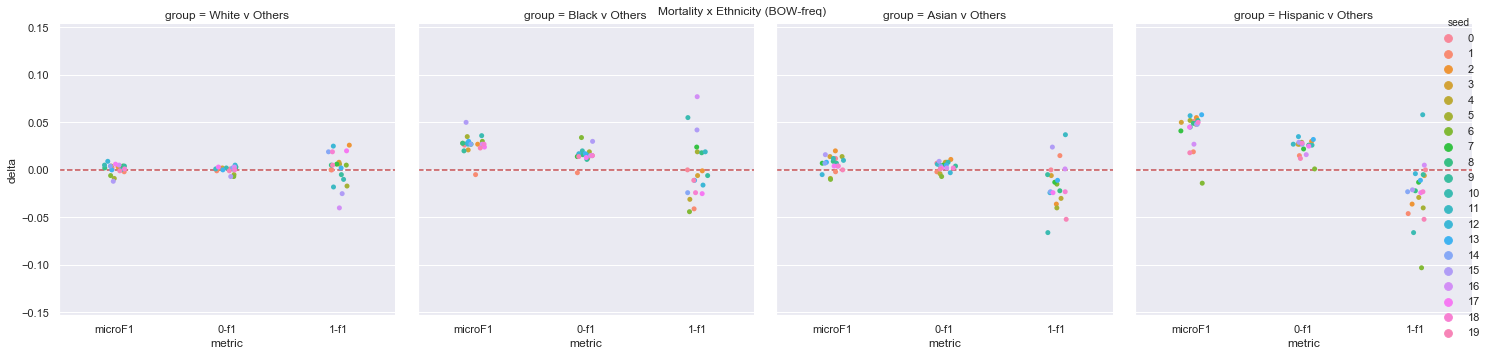

In [9]:
ethinicity_analysis(df_mortality,"TEXT","EXPIRE", "BOW-freq", "Mortality x Ethnicity")

## readmissions


In [44]:
df_readmission = pd.read_csv(out_data_path+"readmissions.csv",sep="\t", header=None, names=["READMISSION","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
df_readmission

,READMISSION,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,1,admission date: [**2149-6-2**] discharg...,F,NaN,NaN
1,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
2,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
3,1,admission date: [**2133-9-3**] d...,M,NaN,NaN
4,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
...,...,...,...,...,...
35827,0,admission date: [**2176-1-21**] dischar...,M,OTHER,OTHER
35828,0,admission date: [**2140-6-28**] dischar...,F,WHITE,WHITE
35829,0,admission date: [**2116-8-10**] ...,F,WHITE,WHITE
35830,0,admission date: [**2201-5-26**] ...,F,WHITE,WHITE


M: 4024 | F: 3144


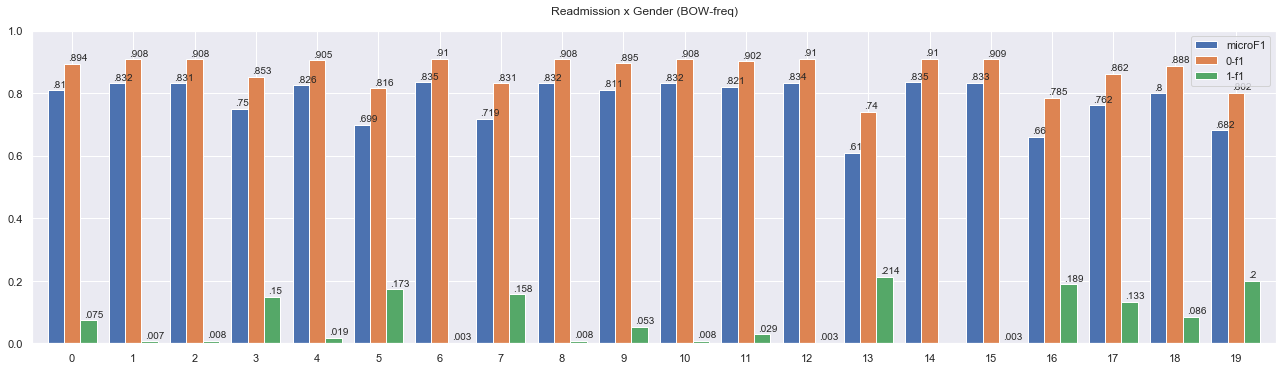

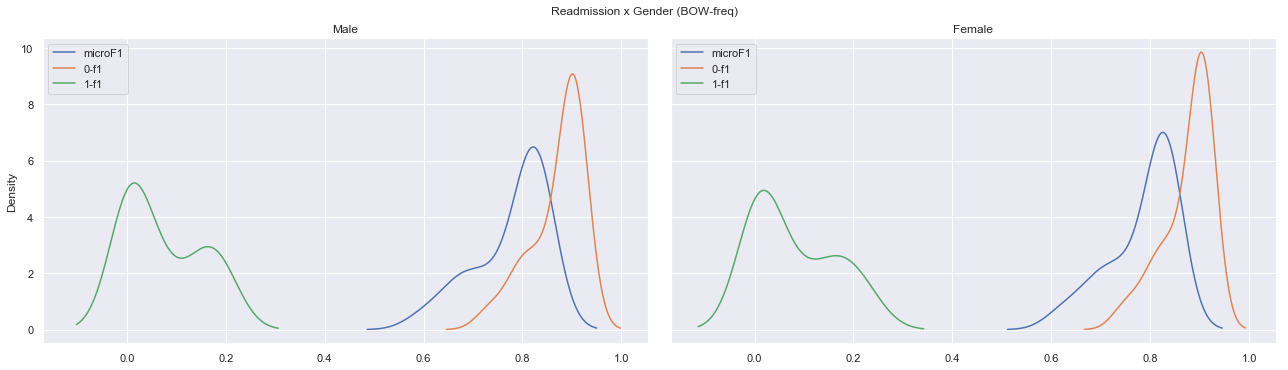

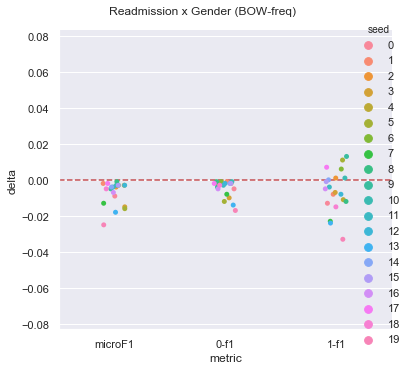

In [48]:
gender_analysis(df_readmission,"TEXT","READMISSION", "BOW-freq", "Readmission x Gender")

M: 4234 | F: 2934
M: 955 | F: 6213


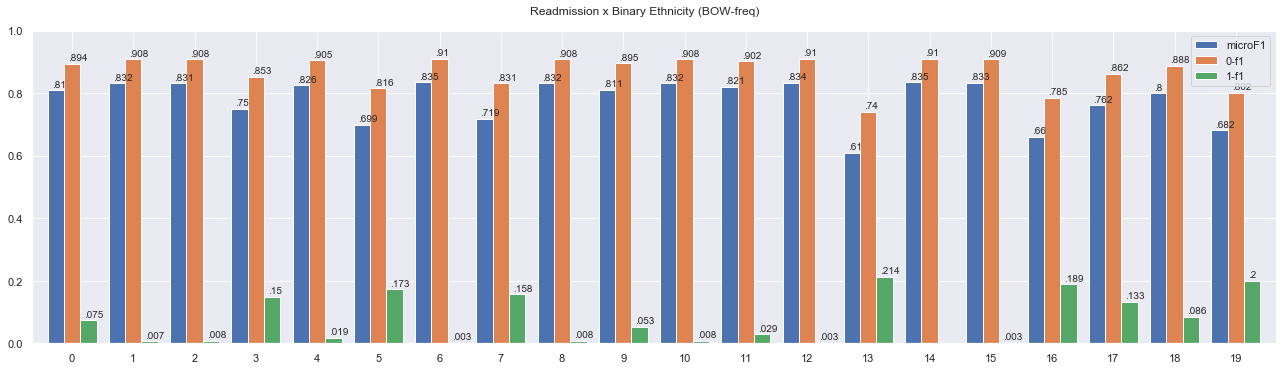

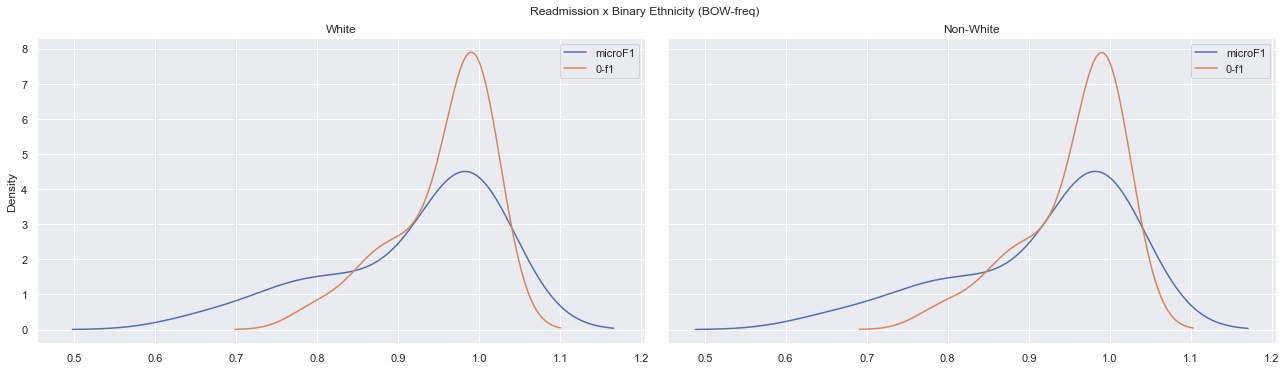

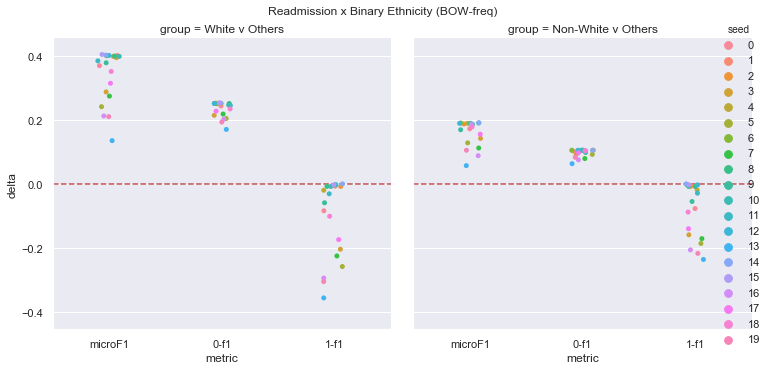

In [49]:
ethnicity_binary_analysis(df_readmission,"TEXT","READMISSION", "BOW-freq", "Readmission x Binary Ethnicity")

M: 4234 | F: 2934
M: 572 | F: 6596
M: 172 | F: 6996
M: 202 | F: 6966


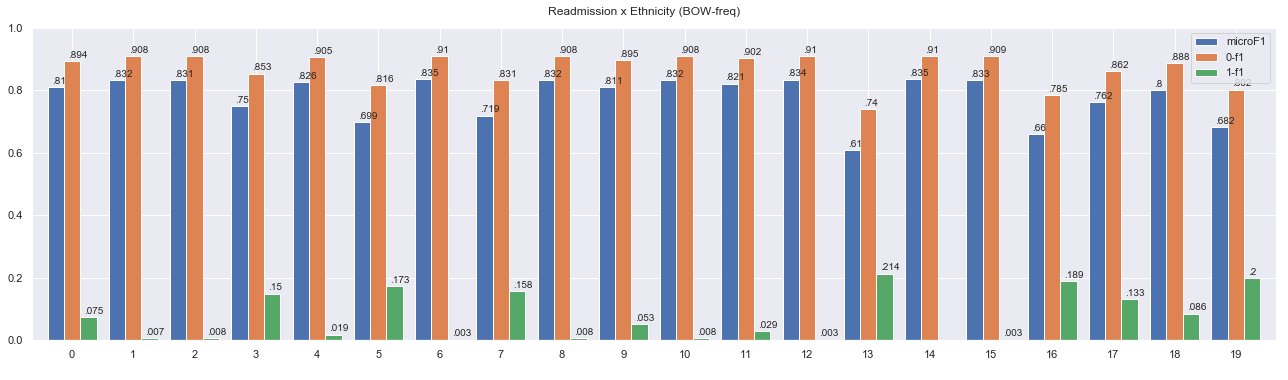

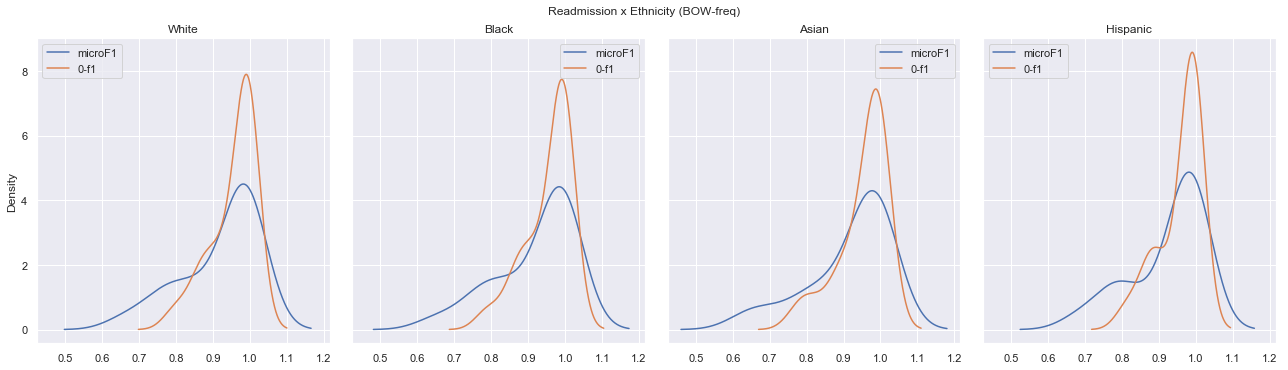

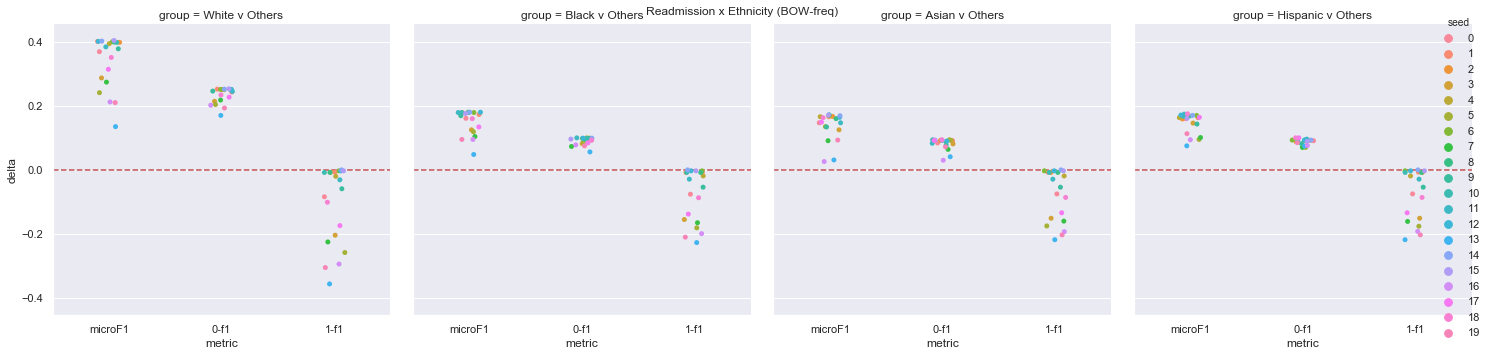

In [50]:
ethinicity_analysis(df_readmission,"TEXT","READMISSION", "BOW-freq", "Readmission x Ethnicity")

# Manual Analysis

In [21]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
cycle

In [26]:
df_readmission = pd.read_csv(out_data_path+"readmissions.csv",sep="\t", header=None, names=["READMISSION","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
df_readmission

,READMISSION,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,1,admission date: [**2149-6-2**] discharg...,F,NaN,NaN
1,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
2,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
3,1,admission date: [**2133-9-3**] d...,M,NaN,NaN
4,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
...,...,...,...,...,...
35827,0,admission date: [**2176-1-21**] dischar...,M,OTHER,OTHER
35828,0,admission date: [**2140-6-28**] dischar...,F,WHITE,WHITE
35829,0,admission date: [**2116-8-10**] ...,F,WHITE,WHITE
35830,0,admission date: [**2201-5-26**] ...,F,WHITE,WHITE


In [31]:
x_label="TEXT"
y_label="READMISSION"
feature_type="BOW-freq"
df=df_readmission
#GENDER
# df_res, df_res_M, df_res_F, df_res_delta = gender_outcome_anaylsis(df, x_label, y_label, feature_type)
#ETHNICITY
df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H  = ethinicity_outcome_anaylsis(df, x_label, y_label, feature_type)





M: 4234 | F: 2934
M: 572 | F: 6596
M: 172 | F: 6996
M: 202 | F: 6966


0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
Name: 1-f1, dtype: float64
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
Name: 1-f1, dtype: float64
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
Name: 1-f1, dtype: float64
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
Name: 1-f1, dtype: float64


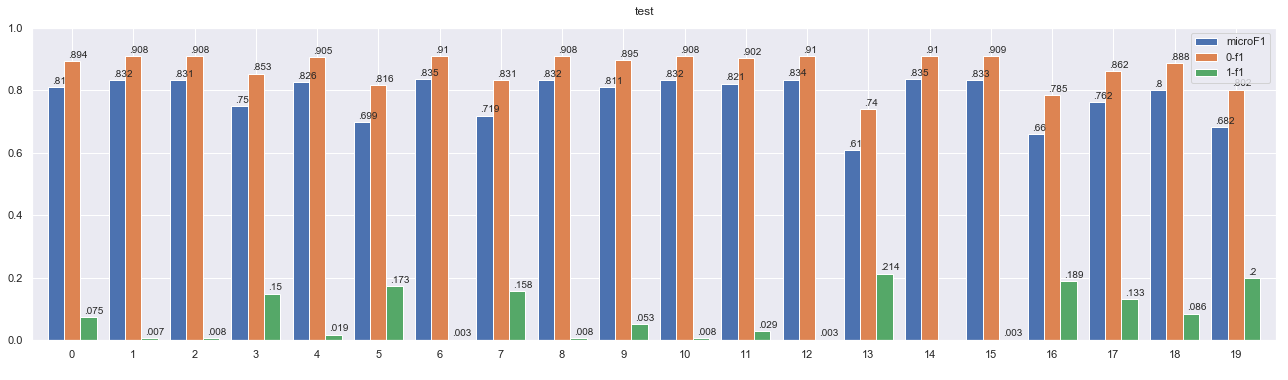

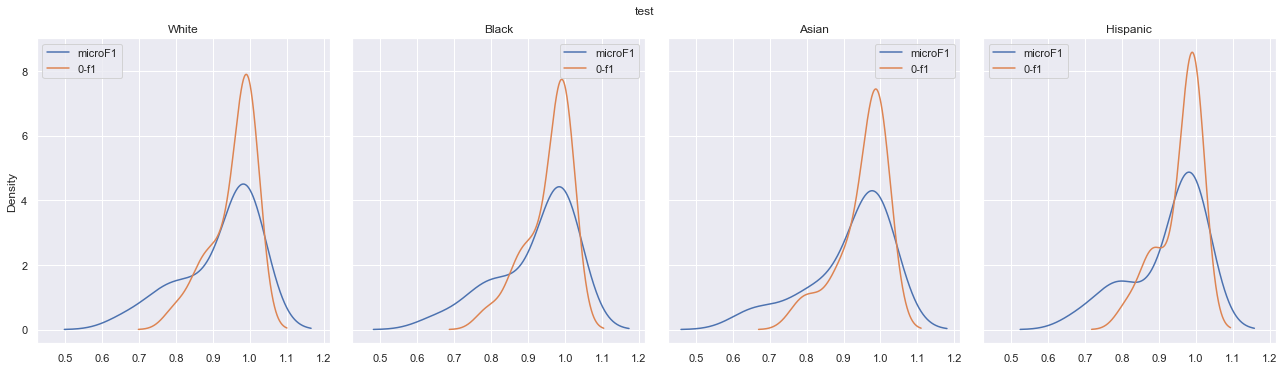

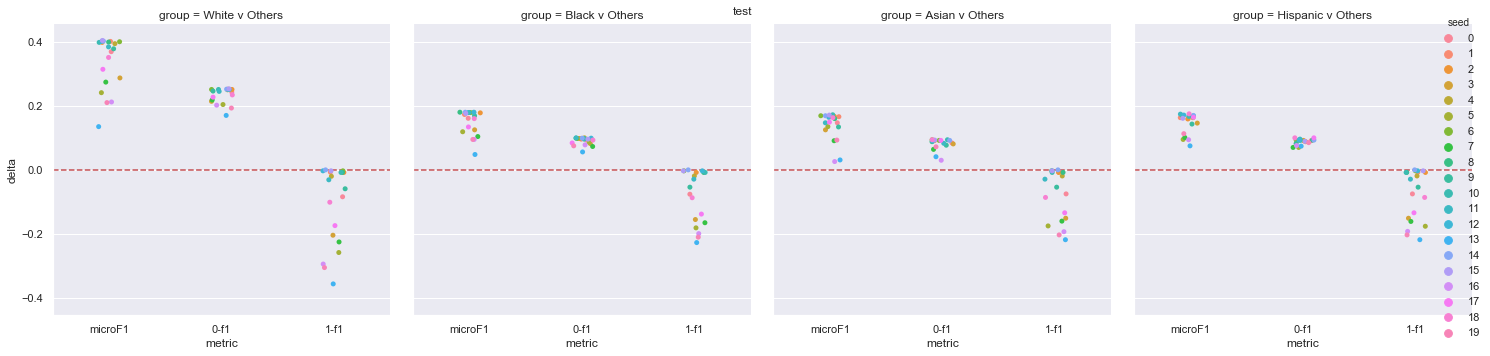

In [36]:
title="test"
#GENDER
# gender_plot_performance(df_res, title)
# gender_plot_densities(df_res_M, df_res_F, title)
# gender_plot_deltas(df_res_delta, title)
#ETHNICITY
ethinicity_plot_performance(df_res, title)
ethnicity_plot_densities(df_res_W, df_res_N, df_res_A, df_res_H, title)
ethinicity_plot_deltas(df_res_delta_W, df_res_delta_N,df_res_delta_A,df_res_delta_H, title)